## Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/Shareddrives/cis522_project/cleaned_data")

In [4]:
ladieswear = pd.read_csv('filtered_articles.csv')
len(ladieswear)

1988

In [5]:
transactions = pd.read_csv("filtered_transactions.csv", index_col=0)
len(transactions)

146499

In [6]:
customers = pd.read_csv('filtered_customer.csv', index_col=0)
len(customers)

4980

In [7]:
ladieswear.columns

Index(['Unnamed: 0', 'article_id', 'product_code', 'prod_name',
       'product_type_no', 'product_type_name', 'product_group_name',
       'graphical_appearance_no', 'graphical_appearance_name',
       'colour_group_code', 'colour_group_name', 'perceived_colour_value_id',
       'perceived_colour_value_name', 'perceived_colour_master_id',
       'perceived_colour_master_name', 'department_no', 'department_name',
       'index_code', 'index_name', 'index_group_no', 'index_group_name',
       'section_no', 'section_name', 'garment_group_no', 'garment_group_name',
       'detail_desc'],
      dtype='object')

In [8]:
ladieswear = ladieswear.drop(columns='Unnamed: 0')
ladieswear.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [9]:
ladieswear.colour_group_name.unique()

array(['Black', 'White', 'Light Beige', 'Light Grey', 'Greyish Beige',
       'Dark Green', 'Red', 'Grey', 'Beige', 'Light Blue', 'Yellow',
       'Dark Blue', 'Blue', 'Off White', 'Dark Red', 'Gold', 'Dark Grey',
       'Dark Turquoise', 'Greenish Khaki', 'Light Pink', 'Light Orange',
       'Yellowish Brown', 'Pink', 'Dark Pink', 'Turquoise',
       'Light Turquoise', 'Green', 'Other Purple', 'Dark Beige',
       'Dark Yellow', 'Light Yellow', 'Orange', 'Light Green',
       'Dark Orange', 'Other Green', 'Other Yellow', 'Other Pink'],
      dtype=object)

## Model

### One-Hot Encoding

In [10]:
lady_attr = ladieswear[['product_type_name','product_group_name','colour_group_name','department_name','index_name','garment_group_name','section_name']]

In [11]:
lady_attr_dummies = pd.get_dummies(lady_attr)
lady_attr_dummies.head(1)

,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blazer,product_type_name_Blouse,product_type_name_Bodysuit,product_type_name_Boots,product_type_name_Bra,product_type_name_Cardigan,...,section_name_Womens Everyday Collection,section_name_Womens Jackets,section_name_Womens Lingerie,"section_name_Womens Nightwear, Socks & Tigh",section_name_Womens Premium,section_name_Womens Shoes,section_name_Womens Small accessories,"section_name_Womens Swimwear, beachwear",section_name_Womens Tailoring,section_name_Womens Trend
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# x1=lady_attr_dummies[1:]

In [22]:
id = ladieswear[['article_id']]
id.head(1)

,article_id
0,108775015


In [23]:
lady_final = pd.concat([lady_attr_dummies, id], axis=1)

In [24]:
X = lady_final.iloc[:,:-1] 

### NearestNeighbors

For each customer c, we get a list of all articles bought by c: a1,...a_n, which will be passed to the function get_scores. Within get_scores, for each article A from the complete set of 1988 articles, we sum up the distance between A and a_i for all i = 1,...,n to get a single score for A with respect to all items bought by customer c. 

In [16]:
from scipy.spatial.distance import cdist
def get_scores(article_list): 
  '''
   given a set of article_id's
   return a dataframe (article_id, score) with top 50 items 
   that are most similar to those articles 
   (articles with the highest overall scores)
  '''
  
  res_df = pd.DataFrame(columns=['article_id', 'score'])
  D = np.zeros((len(ladieswear),len(article_list))) # all distances
  if len(article_list)>0:
    for i in range(len(article_list)):
      a = lady_final[lady_final['article_id']==article_list[i]].drop(columns='article_id').values
      distances = cdist(X.values, a, metric='euclidean').reshape(-1)
      D[:,i] = distances
      sum_D = D.sum(axis=1)
    # keep the results in res_df
    res_df['article_id'] = lady_final['article_id']
    res_df['score'] = sum_D
    # eliminate items already in article_list
    res_df = res_df[~res_df['article_id'].isin(set(article_list))]
    # sort the df by score and keep only the top 50 articles
    res_df = res_df.sort_values('score', ascending=True).head(50)
    
  return res_df

Below we try to make recommendation for a random customer with customer_id 09218960c278039863ca72e08255c245ade5466e3b90bf718a142087b5d27646. We will then visualize the recommendation.

In [27]:
# get the customer id of a random customer
c = customers.iloc[150].customer_id
print(c)

09218960c278039863ca72e08255c245ade5466e3b90bf718a142087b5d27646


In [28]:
all_transactions = transactions[['customer_id','article_id']].drop_duplicates()
all_transactions_tuples = all_transactions.itertuples(index=False)
all_transactions_set = set([tuple(x) for x in all_transactions_tuples])

In [29]:
# get all transactions from this customer
article_list = list(all_transactions[all_transactions.customer_id==c].article_id)
# get recommendation 
full_recommendation = get_scores(article_list)

In [30]:
full_recommendation

,article_id,score
1058,733419002,27.284056
568,663942005,27.284056
1079,735404001,27.284056
1165,744180002,27.284056
1697,817353008,27.284056
1518,787237006,27.284056
1519,787285001,27.284056
1524,787696004,27.284056
1938,865520003,27.284056
1695,817353002,27.284056


## Visualization

We first visualize the articles the customer actually bought.

In [33]:
import cv2
# make a 3*5 grid 
images = []
for id in article_list:
  item = id 
  name1 = '/content/drive/Shareddrives/cis522_project/data/images_128_128/'+'0'+str(item)[:2]+'/0'+str(item)+'.jpg'
  images.append(cv2.imread(name1)[:,:,::-1])


In [32]:
len(images)

13

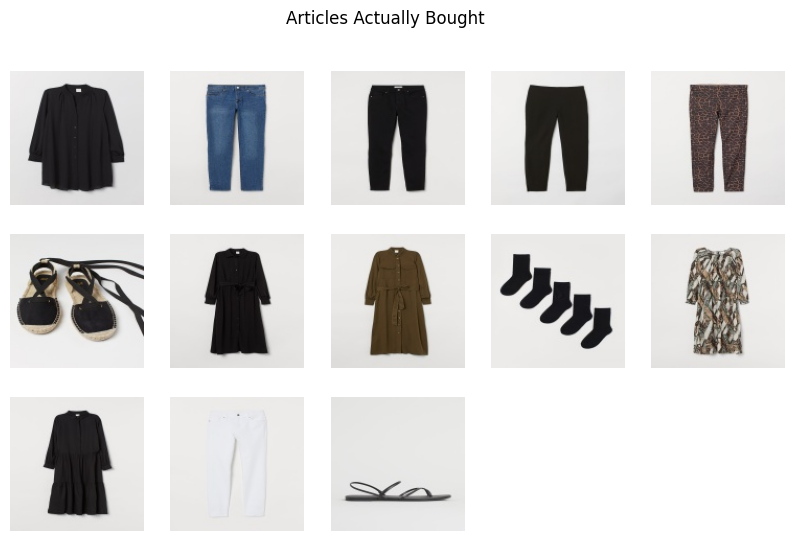

In [39]:
fig, axs = plt.subplots(3,5,figsize=(10,6))
fig.suptitle('Articles Actually Bought')
for i in range(3):
  for j in range(5):
    axs[i,j].grid(False)
    axs[i,j].axis("off")
    try:
      img = images[i*5+j%5]
      axs[i,j].imshow(img)
    except:
      continue

Then we can visualize the recommended articles for this customer.

In [37]:
import cv2
rec_images = []
for id in full_recommendation.article_id:
  item = id 
  name1 = '/content/drive/Shareddrives/cis522_project/data/images_128_128/'+'0'+str(item)[:2]+'/0'+str(item)+'.jpg'
  rec_images.append(cv2.imread(name1)[:,:,::-1])

In [38]:
len(rec_images)

50

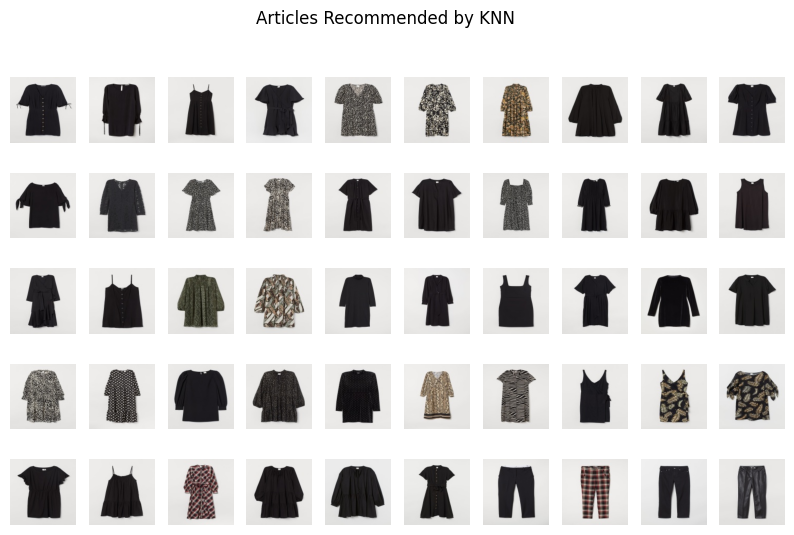

In [40]:
fig, axs = plt.subplots(5,10,figsize=(10,6))
fig.suptitle('Articles Recommended by KNN')
for i in range(5):
  for j in range(10):
    axs[i,j].grid(False)
    axs[i,j].axis("off")
    try:
      img = rec_images[i*10+j%10]
      axs[i,j].imshow(img)
    except:
      continue
fig.savefig('Articles Recommended by KNN.png', dpi = 1000)

## Evaluate

We evaluate the model with hit rate. For each of the customers making transactions on A articles, for i = 1,..,A, we make 50 recommendations based on all but the i-th articles and save the results to an overall res_recommendation dataframe. We then check whether i-th article bought by the customer is in res_recommendation, if yes (for any i), that's a 'hit'. The final accuracy is the number of 'hit' customers divided by the number of all customers. 

In [28]:
from matplotlib.projections.geo import Transform
import warnings
warnings.filterwarnings("ignore")

hit = 0
customer=0
for customer_id in customers.customer_id: # for each customer 
  trans = all_transactions[all_transactions['customer_id'] == customer_id] # all transactions made by this customer
  for i in range(len(trans.article_id)):
    res_recommendation = pd.DataFrame() # will store all recommended articles (for all but the i-th article)
    training_list = list(trans.article_id)[:i] + list(trans.article_id[i+1:])
    full_recommendation_df = get_scores(training_list)
    if len(full_recommendation_df)>0:
      recommended_articles = set(full_recommendation_df.article_id)
      test_id = trans.article_id.iloc[i] # test with the i-th article bought by this customer
      if test_id in recommended_articles:
        hit += 1
        break
  customer+=1
print('Hit Rate: ', hit/len(customers))

Hit Rate:  0.5337349397590362
